In [ ]:
!pip install langchain langchain-openai pandas
!pip install openai
!pip install nest-asyncio
!pip install langchain-experimental
!pip install langchain_core langchain-anthropic langgraph
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 23.6 MB/s eta 0:00:00


In [ ]:
# Install package first
# We use uv for faster installation

# Google Colab is setting some uv-related environment variables, that seem to have broken with the a Colab update.
# The Colab team is tracking this internally (googlecolab/colabtools#5237).
# https://github.com/googlecolab/colabtools/issues/5237#issuecomment-2786440777
import os
os.environ["UV_CONSTRAINT"] = os.environ["UV_BUILD_CONSTRAINT"] = ""  # add this line to solve the uv related issue

!pip install uv
!uv pip install -q autogluon.timeseries --system --prerelease allow
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab


## if there seems to be inconsistency due to numpy & pandas versions, do the following
# !uv pip uninstall pandas numpy
!uv pip install -q --force-reinstall numpy==1.26.4 --system --prerelease allow
!uv pip install -q --force-reinstall pandas==2.2.2 --system --prerelease allow
## You may need to restart colab kernel

In [ ]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [ ]:
!pip install gradio

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/GE_Capstone/AI Agent Workflow/

/content/drive/MyDrive/GE_Capstone/AI Agent Workflow


In [ ]:
import pandas as pd
import numpy as np
import re
import json
import uuid
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.types import Command
from pydantic import BaseModel, Field
from typing import Literal
import nest_asyncio
from langgraph.func import entrypoint, task
from langchain_openai import OpenAI, ChatOpenAI
from langchain_experimental.agents import create_pandas_dataframe_agent

from langchain.docstore.document import Document
import faiss
from langchain.chains import RetrievalQA
from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [ ]:
llm_4 = ChatOpenAI(
	api_key="replace with your api",
    model_name="gpt-4",
    temperature=0.7
)

llm_turbo = ChatOpenAI(
	api_key="replace with your api",
    model_name="gpt-3.5-turbo",
    temperature=0.7
)

llm_o3mini = ChatOpenAI(
	api_key="replace with your api",
    model_name="o3-mini"
)

In [ ]:
class Route(BaseModel):
    step: Literal["forecast", "threshold_exceedance", "slope_calculation", "separate", "text_analysis"] = Field(
        ..., description="The next step in the routing process"
    )

router = llm_4.with_structured_output(Route)

# ==== Supervisor Node ====
def llm_supervisor_node(state: MessagesState) -> Command[str]:
    user_msg = state["messages"][-1].content
    step = router.invoke([
        SystemMessage(content="Route the input to forecast, threshold_exceedance, slope_calculation, text_analysis, or separate based on the user's request."),
        HumanMessage(content=user_msg),
    ]).step
    return Command(update={"messages": state["messages"]}, goto=step)

# ==== Forecast Node ====
def chronos_forecast_node(state: MessagesState) -> Command:
    import re, json, os
    from uuid import uuid4

    user_msg = state["messages"][-1].content
    match = re.search(r"'([^']+\.csv)'", user_msg)
    pred_len_match = re.search(r"(\d+)\s+(?:days|steps)", user_msg)

    if not match or not pred_len_match:
        return Command(update={"messages": state["messages"] + [AIMessage(content="Error: Missing file path or prediction length.")]}, goto="end")

    file_path = match.group(1)
    pred_len = int(pred_len_match.group(1))

    df = pd.read_csv(file_path)[["item_id", "timestamp", "target"]]
    tsdf = TimeSeriesDataFrame.from_data_frame(df, id_column="item_id", timestamp_column="timestamp")
    train_data, test_data = tsdf.train_test_split(pred_len)
    predictor = TimeSeriesPredictor(prediction_length=pred_len).fit(train_data, presets="bolt_small")
    predictions = predictor.predict(train_data)
    leaderboard = predictor.leaderboard(test_data)
    model_name = leaderboard.iloc[0]["model"]
    mape = -leaderboard.iloc[0]["score_test"]

    predictions_df = predictions.to_data_frame().reset_index()
    preview = predictions_df[["item_id", "timestamp", "mean"]].tail(10).to_string(index=False)

    # === Save to CSV for download ===
    output_path = f"forecast_result_{uuid4().hex[:8]}.csv"
    predictions_df.to_csv(output_path, index=False)

    result = {
        "message": f"Top model: {model_name}, MAPE: {mape * 100:.2f}%\nForecast Preview:\n{preview}",
        "download_path": output_path
    }

    return Command(update={"messages": state["messages"] + [AIMessage(content=json.dumps(result))]}, goto="end")


# ==== build agent for LangChain Pandas to use ====
def build_agent_from_prompt(llm, prompt: str):
    import re
    match = re.search(r"[\"'](?P<filename>[^\"']+\.csv)[\"']", prompt)
    if not match:
        raise ValueError("No CSV file name found in prompt.")
    file_path = match.group("filename")

    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        raise ValueError(f"Failed to load CSV file: {file_path}") from e

    agent = create_pandas_dataframe_agent(llm, df, verbose=True, allow_dangerous_code=True)
    return agent

# ==== Slope Node ====
def slope_agent_node(state: MessagesState) -> Command:
    prompt = state["messages"][-1].content
    agent = build_agent_from_prompt(llm_4, prompt)
    result = agent.invoke(prompt)
    content = result.get("output", str(result))
    return Command(update={"messages": state["messages"] + [AIMessage(content=content)]}, goto="end")

# ==== Threshold Node ====
def threshold_agent_node(state: MessagesState) -> Command:
    prompt = state["messages"][-1].content
    agent = build_agent_from_prompt(llm_turbo, prompt)
    result = agent.invoke(prompt)
    content = result.get("output", str(result))
    return Command(update={"messages": state["messages"] + [AIMessage(content=content)]}, goto="end")

# === Text Analysis Node ===
def text_analysis_node(state: MessagesState) -> Command:
    user_msg = state["messages"][-1].content
    match = re.search(r"'([^']+\.txt)'", user_msg)
    if not match:
        return Command(update={"messages": state["messages"] + [AIMessage(content="Error: Missing .txt file in prompt.")]}, goto="end")
    file_path = match.group(1)

    try:
        with open(file_path, "r", encoding="utf-8") as f:
            content = f.read()
    except Exception as e:
        return Command(update={"messages": state["messages"] + [AIMessage(content=f"Failed to load file: {e}")]} , goto="end")

    documents = [Document(page_content=content)]

    embedding_model = OpenAIEmbeddings(openai_api_key="replace with your api")
    vectorstore = FAISS.from_documents(documents, embedding_model)
    qa_chain = RetrievalQA.from_chain_type(llm=llm_o3mini, retriever=vectorstore.as_retriever())

    query = state["messages"][-1].content
    result = qa_chain.invoke(query)
    return Command(update={"messages": state["messages"] + [AIMessage(content=result['result'])]}, goto="end")

# ==== Separate Node ====
def separate_worker_node(state: MessagesState) -> Command:
    user_msg = state["messages"][-1].content

    result = llm_4.invoke(user_msg)
    prompts = result.content.splitlines()

    all_outputs = []
    for prompt in prompts:
        prompt = prompt.strip()
        if not prompt:
            continue
        print(f"[Separate] Sub-prompt: {prompt}")

        sub_state = {"messages": [HumanMessage(content=prompt)]}
        sub_result = graph.invoke(sub_state)

        if "messages" in sub_result and isinstance(sub_result["messages"], list):
            output_msg = sub_result["messages"][-1]
            if hasattr(output_msg, "content"):
                all_outputs.append(f"Prompt: {prompt}\nResult: {output_msg.content}")
            else:
                all_outputs.append(f"Prompt: {prompt}\nResult: [No content returned]")
        else:
            all_outputs.append(f"Prompt: {prompt}\nResult: [Invalid result structure]")

    summary = "\n\n".join(all_outputs)
    return Command(update={"messages": state["messages"] + [AIMessage(content=summary)]}, goto="end")

/usr/local/lib/python3.11/dist-packages/langchain_openai/chat_models/base.py:1660: UserWarning: Cannot use method='json_schema' with model gpt-4 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [ ]:
builder = StateGraph(MessagesState)

builder.add_node("supervisor", llm_supervisor_node)
builder.add_node("forecast", chronos_forecast_node)
builder.add_node("threshold_exceedance", threshold_agent_node)
builder.add_node("slope_calculation", slope_agent_node)
builder.add_node("text_analysis", text_analysis_node)
builder.add_node("separate", separate_worker_node)

builder.set_entry_point("supervisor")
builder.add_edge("forecast", END)
builder.add_edge("threshold_exceedance", END)
builder.add_edge("slope_calculation", END)
builder.add_edge("text_analysis", END)
builder.add_edge("separate", END)

graph = builder.compile()

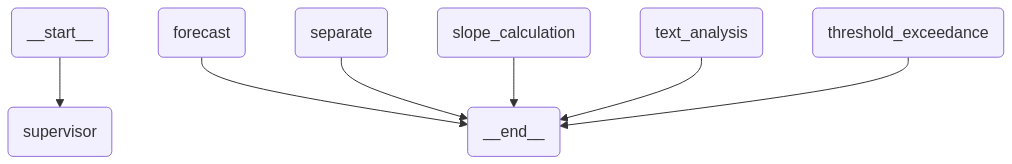

In [ ]:
from IPython.display import display, Image
# print("Compiled graph id:", id(graph))
# print("Mermaid graph id:", id(graph))
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
import gradio as gr
from langchain_core.messages import HumanMessage

def run_agentic_workflow(task_list, csv_file, txt_file, pred_steps):
    import os, json
    results = []
    forecast_download = None

    file_map = {
        "Forecast": csv_file,
        "Threshold Exceedance": csv_file,
        "Slope Calculation": csv_file,
        "Text Analysis": txt_file
    }

    prompts = []
    for task in task_list:
        file_obj = file_map[task]
        if file_obj is None:
            results.append(f"[{task}]\nError: No file uploaded for this task.\n")
            continue

        file_path = file_obj.name

        if task == "Forecast":
            prompts.append(f"Please forecast the next {pred_steps} days using the file '{file_path}'.")
        elif task == "Threshold Exceedance":
            prompts.append(f"Use the file '{file_path}' to calculate the 95% threshold for target column of df, then display the list of values in the target column that exceed the 95% value only.")
        elif task == "Slope Calculation":
            prompts.append(f"Use the file '{file_path}' to calculate the slope of values in the target column of df, then return the slope of target column only.")
        elif task == "Text Analysis":
            prompts.append(f"Extract all instances where maintenance was performed from the text file '{file_path}' based on the description column, do not include routine maintenance, give me the record ID and dates where maintenance was performed as list where each element is quoted.")
    for prompt in prompts:
        state = {"messages": [HumanMessage(content=prompt)]}
        result = graph.invoke(state)
        content = result["messages"][-1].content

        try:
            parsed = json.loads(content)
            results.append(parsed["message"])
            if "forecast" in prompt.lower():
                forecast_download = parsed.get("download_path")
        except:
            results.append(content)

    return "\n\n".join(results), forecast_download

In [ ]:
import gradio as gr

with gr.Blocks(theme=gr.themes.Default(primary_hue="indigo")) as demo:
    gr.Markdown(
    """
    <div style="text-align: center">
        <h1>📈 LangGraph Agentic Workflow Dashboard</h1>
        <p><strong>An interactive multi-agent system for time series forecasting, anomaly detection, and text analysis.</strong></p>
    </div>
    """,
    elem_id="title-block"
    )

    with gr.Row():
        with gr.Column():
            task_input = gr.CheckboxGroup(
                ["Forecast", "Threshold Exceedance", "Slope Calculation", "Text Analysis"],
                label="✅ Select Tasks",
                info="You can select one or more tasks to execute"
            )
            pred_input = gr.Slider(1, 200, value=24, label="🔢 Prediction Steps (Forecasting Only)")

        with gr.Column():
            csv_input = gr.File(file_types=[".csv"], label="📂 Upload CSV File (for time series tasks)")
            txt_input = gr.File(file_types=[".txt"], label="📝 Upload TXT File (for text analysis)")
            run_button = gr.Button("🚀 Run Agent Workflow", variant="primary")

    gr.Markdown("---")

    with gr.Group():
        gr.Markdown("### 🧠 Agent Output")
        output_text = gr.Textbox(label="", lines=20, interactive=False)

    with gr.Group():
        gr.Markdown("### ⬇️ Forecast CSV Download")
        download_output = gr.File(label="", interactive=False)

    run_button.click(
        fn=run_agentic_workflow,
        inputs=[task_input, csv_input, txt_input, pred_input],
        outputs=[output_text, download_output]
    )

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d12e78a3a770f35f92.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
